In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from tqdm import tqdm
from interleaver_parameters import *
from interleaver_2_stages import interleaver_2_stage_calc, calculate_spectrum_bandwidth

In [2]:
gf45clo_pdk_sin_neff_ng_variability = pd.read_csv("gf45clo_pdk_sin_neff_ng_variability.csv")
gf45clo_sin_neff_ng_variability = gf45clo_pdk_sin_neff_ng_variability[
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_width']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_height']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_sidewall_angle']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['wg_width (nm)']<1.5)
]

In [3]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3 = 0.9,
    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0']),
    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0']),
    
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

dL for 400Ghz FSR:  0.00038810416314973483
  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000    0.848157 -1.512719  4815.807692
  10    0.505000    0.635000    0.895800    0.787768 -1.492751  4736.822838
  20    0.503490    0.635000    0.896435    0.598709 -1.481069  4648.063055
  30    0.501061    0.632989    0.898746    0.042890 -1.118177  4461.526368
  40    0.495000    0.631464    0.905000   -2.009618 -0.574211  3068.698005
  50    0.495000    0.632163    0.904842   -3.756744 -0.183250  3453.523474
  60    0.495000    0.632138    0.904983   -3.534349 -0.055039  3114.051854
  70    0.495000    0.629224    0.904835   -2.772855  0.002844  2444.720974
  80    0.495000    0.625000    0.904566   -2.161184  0.544688  1991.960390
  90    0.495000    0.625000    0.904301   -2.432856  1.738180  1182.027406
 100    0.495000    0.625000    0.904069   -1.916268  2.355623  1148.015285
 110    0.495000    0.625000    0.904161   -1.989517  

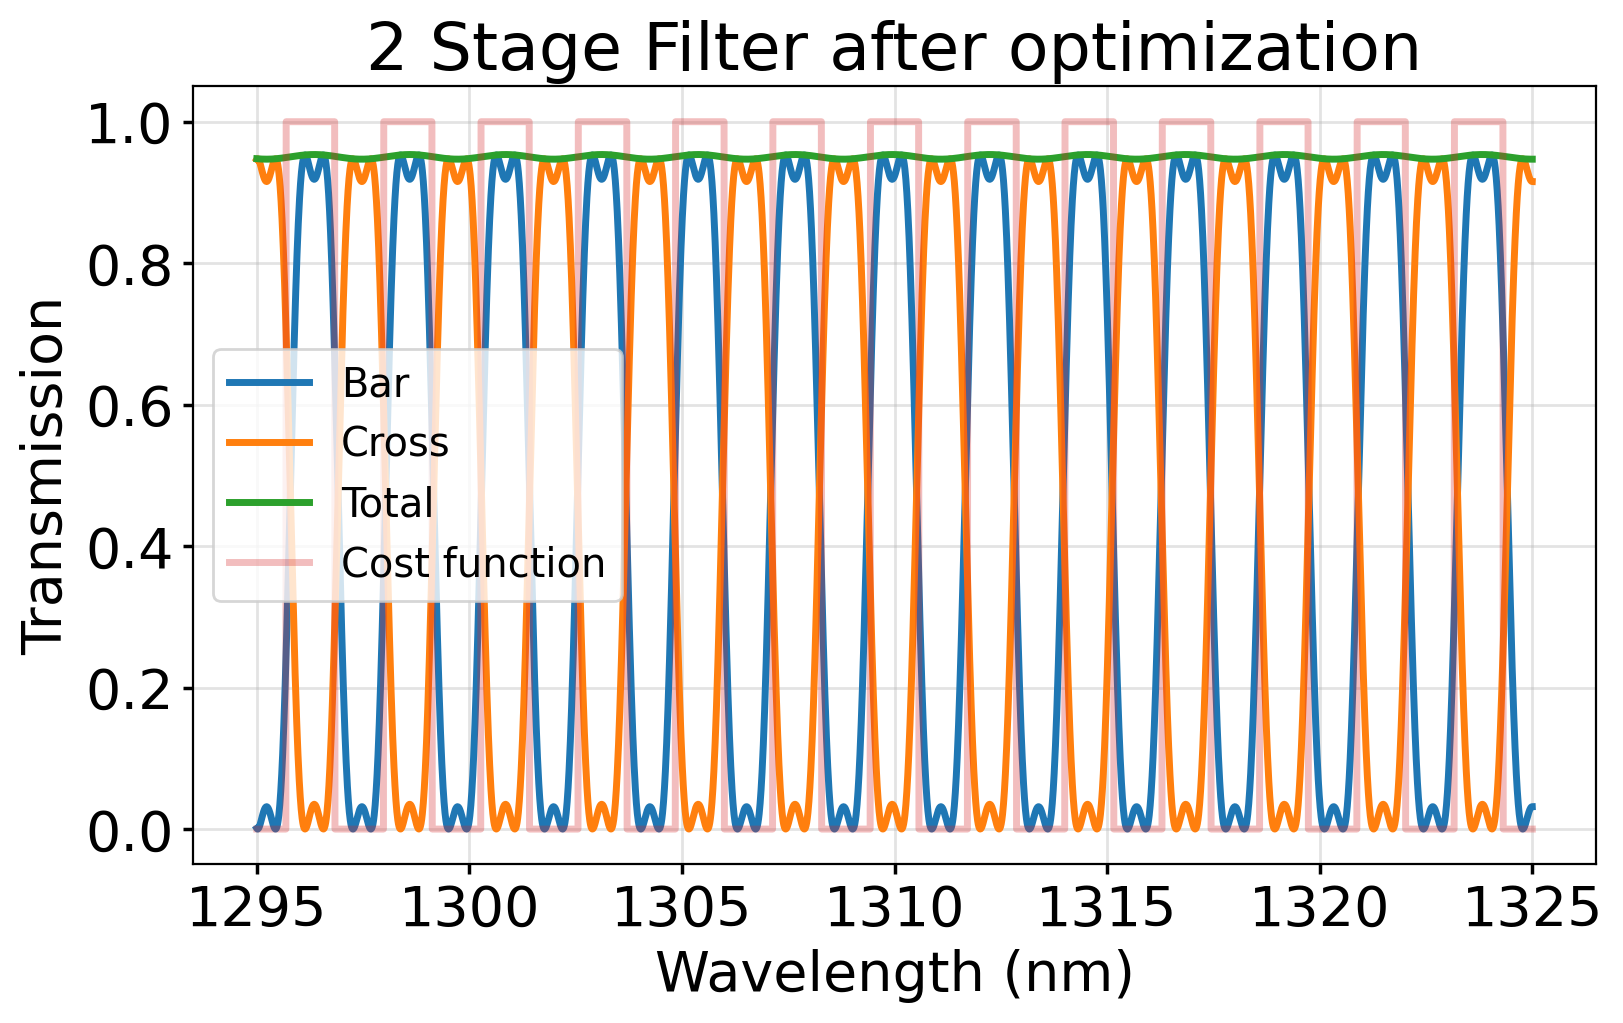

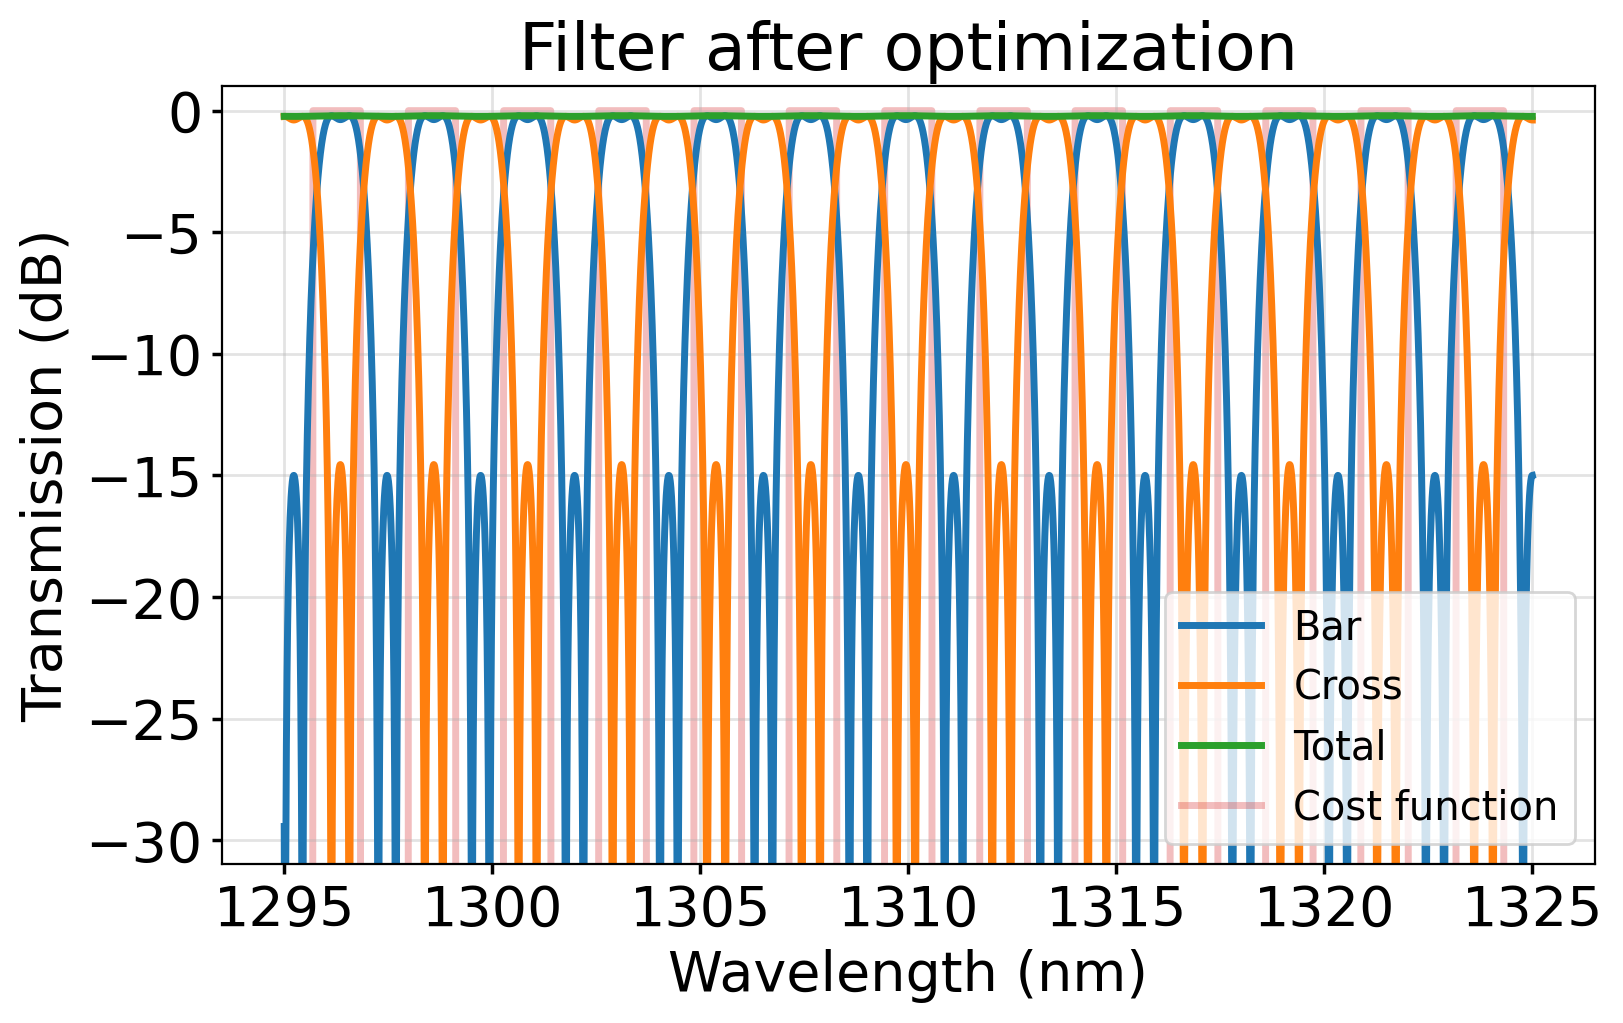

In [4]:
interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [5]:
Channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9]

# Coupler variation study


## Process variations only in directional couplers and the waveguide

In [6]:
# Create compound effect of the three filter stages on top of each other
um = 1e-6
insertion_loss_storage = []
dc1_storage = []
dc2_storage = []
dc3_storage = []

# DC values = [0.495132    0.630014    0.896570]
total_bar_port_storage = []
total_cross_port_storage = []
bar_port_fom = []
cross_port_fom = []

# for i in tqdm(range(len(gf45clo_sin_neff_ng_variability['neff_freq0'].values)),desc='DC split-ratio variation sweep'):
for i in tqdm(range(10),desc='DC split-ratio variation sweep'):
    rand_variable_dc1 = np.random.normal(0,random_variable_sigma) 
    # rand_variable_dc2 = np.random.normal(0,random_variable_sigma) 
    # rand_variable_dc3 = np.random.normal(0,random_variable_sigma) 

    rand_dc1 = (1+rand_variable_dc1)*0.495
    rand_dc2 = (1+rand_variable_dc1)*0.630
    rand_dc3 = (1+rand_variable_dc1)*0.895

    #Clamp values between 0 and 1
    rand_dc1 = np.clip(rand_dc1,a_min=0,a_max=1)
    rand_dc2 = np.clip(rand_dc2,a_min=0,a_max=1)
    rand_dc3 = np.clip(rand_dc3,a_min=0,a_max=1)

    dc1_storage.append(rand_dc1)
    dc2_storage.append(rand_dc2)
    dc3_storage.append(rand_dc3)
    
    variation_interleaver = interleaver_2_stage_calc(
        L = 350*um,
        dL1 = dL_400Ghz_FSR,
        dL2 = 2*dL_400Ghz_FSR,
        dc1 = rand_dc1,
        dc2 = rand_dc2,
        dc3 = rand_dc3,
    )
    variation_interleaver.channel_spacing = FSR_wavelength/8

    variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]
    variation_interleaver.phase_shift_2_top = interleaver_400Ghz_result.x[4]

    new_dev_params = [
        rand_dc1,
        rand_dc2,
        rand_dc3,
        interleaver_400Ghz_result.x[3],
        interleaver_400Ghz_result.x[4],
    ]

    wav,bar_port_first_amp,cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)
    
    total_bar_port_storage.append(bar_port_first_amp)
    total_cross_port_storage.append(cross_port_amp)
    bar_port_fom.append(calculate_spectrum_bandwidth(wav, bar_port_first_amp, IL_channel_offset = Channel_offset_list))
    cross_port_fom.append(calculate_spectrum_bandwidth(wav, cross_port_amp, IL_channel_offset = Channel_offset_list))

total_bar_port_storage = np.array(total_bar_port_storage)
total_cross_port_storage = np.array(total_cross_port_storage)
bar_port_fom_storage = np.array(bar_port_fom)
cross_port_fom_storage = np.array(cross_port_fom)

DC split-ratio variation sweep: 100%|████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


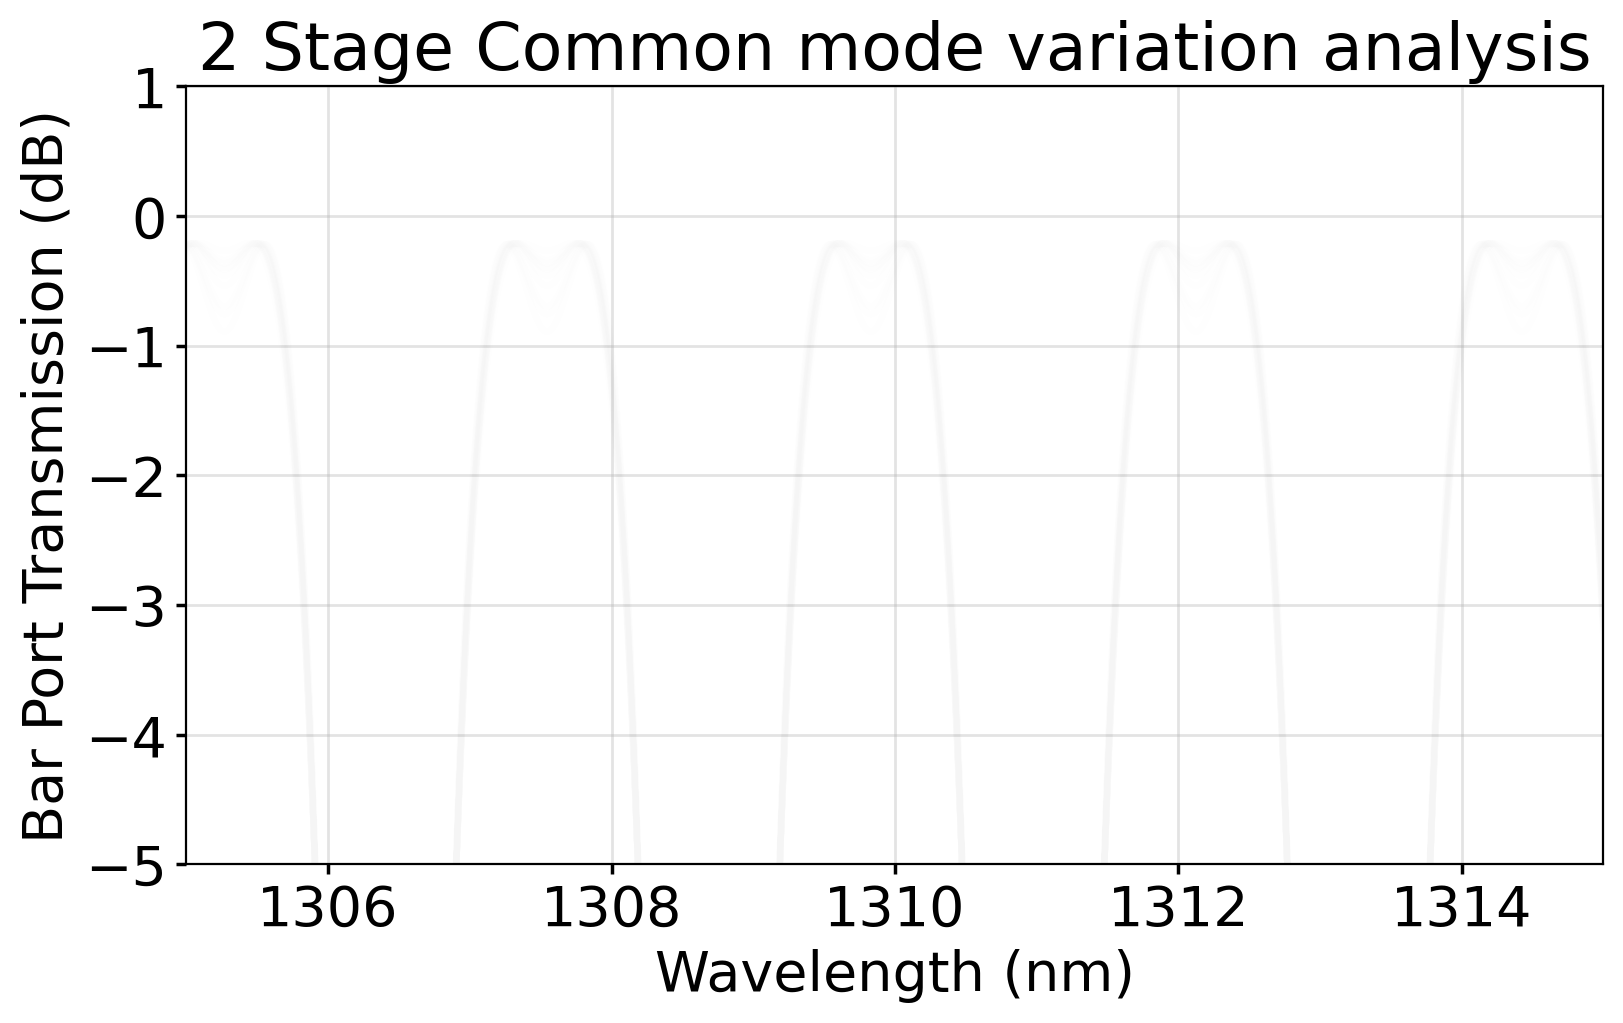

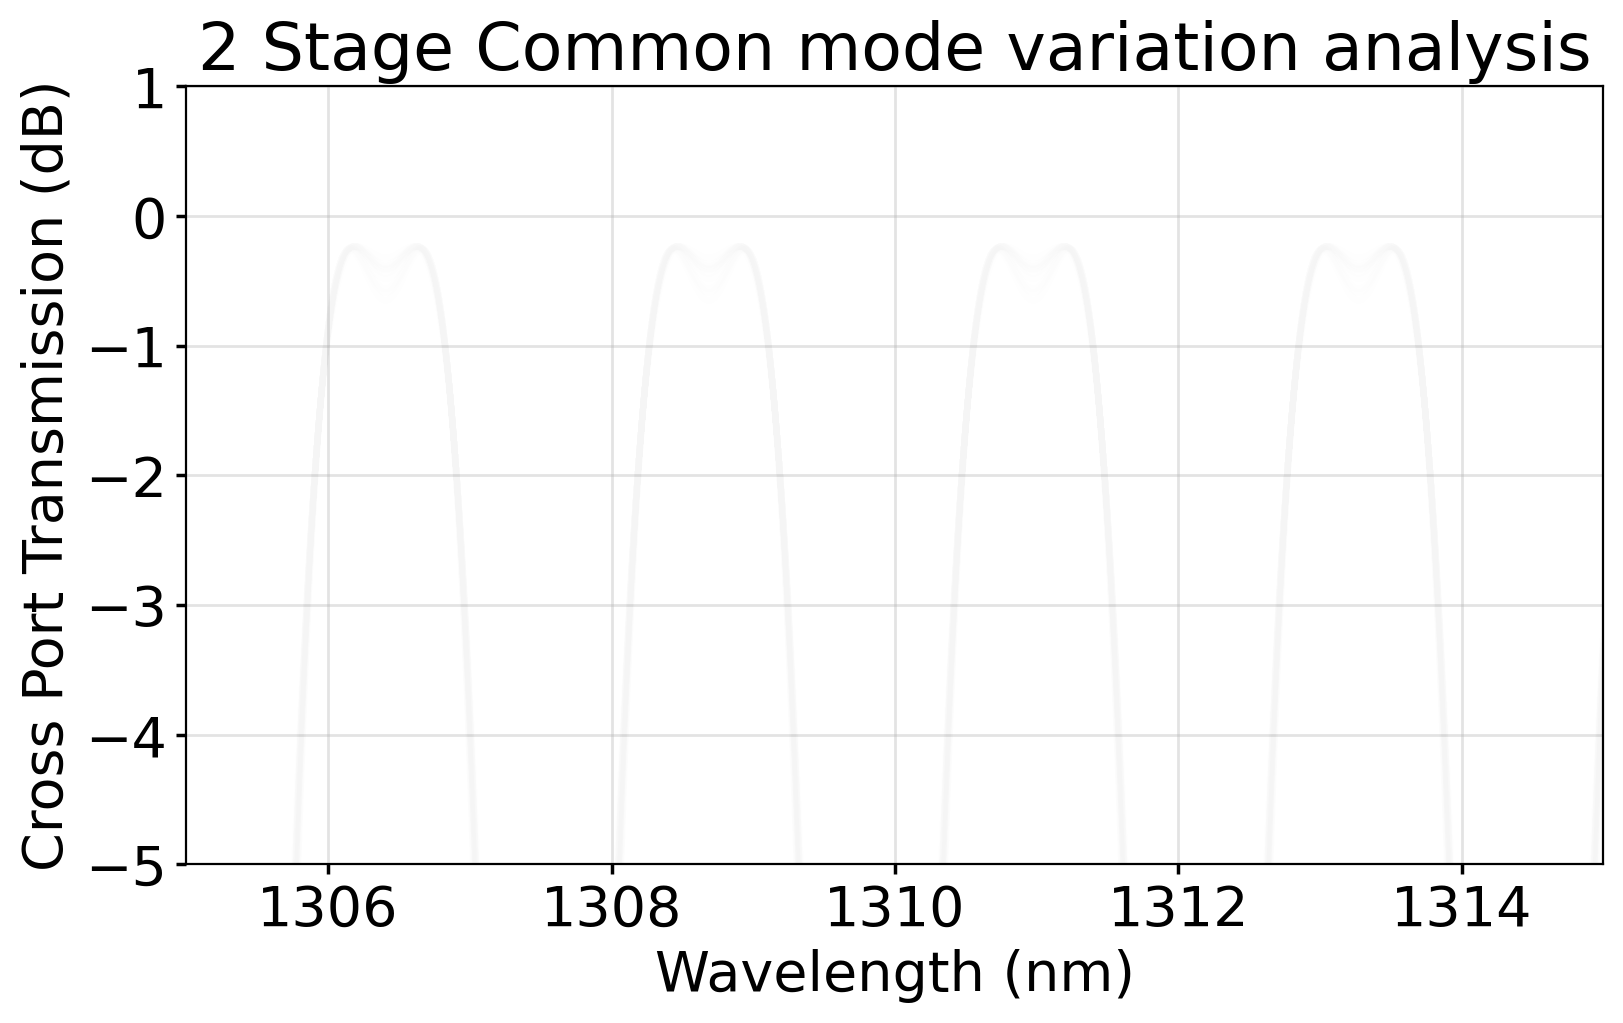

plus sigma is :  0.5016139371336349
minus sigma is :  0.46915071303569034


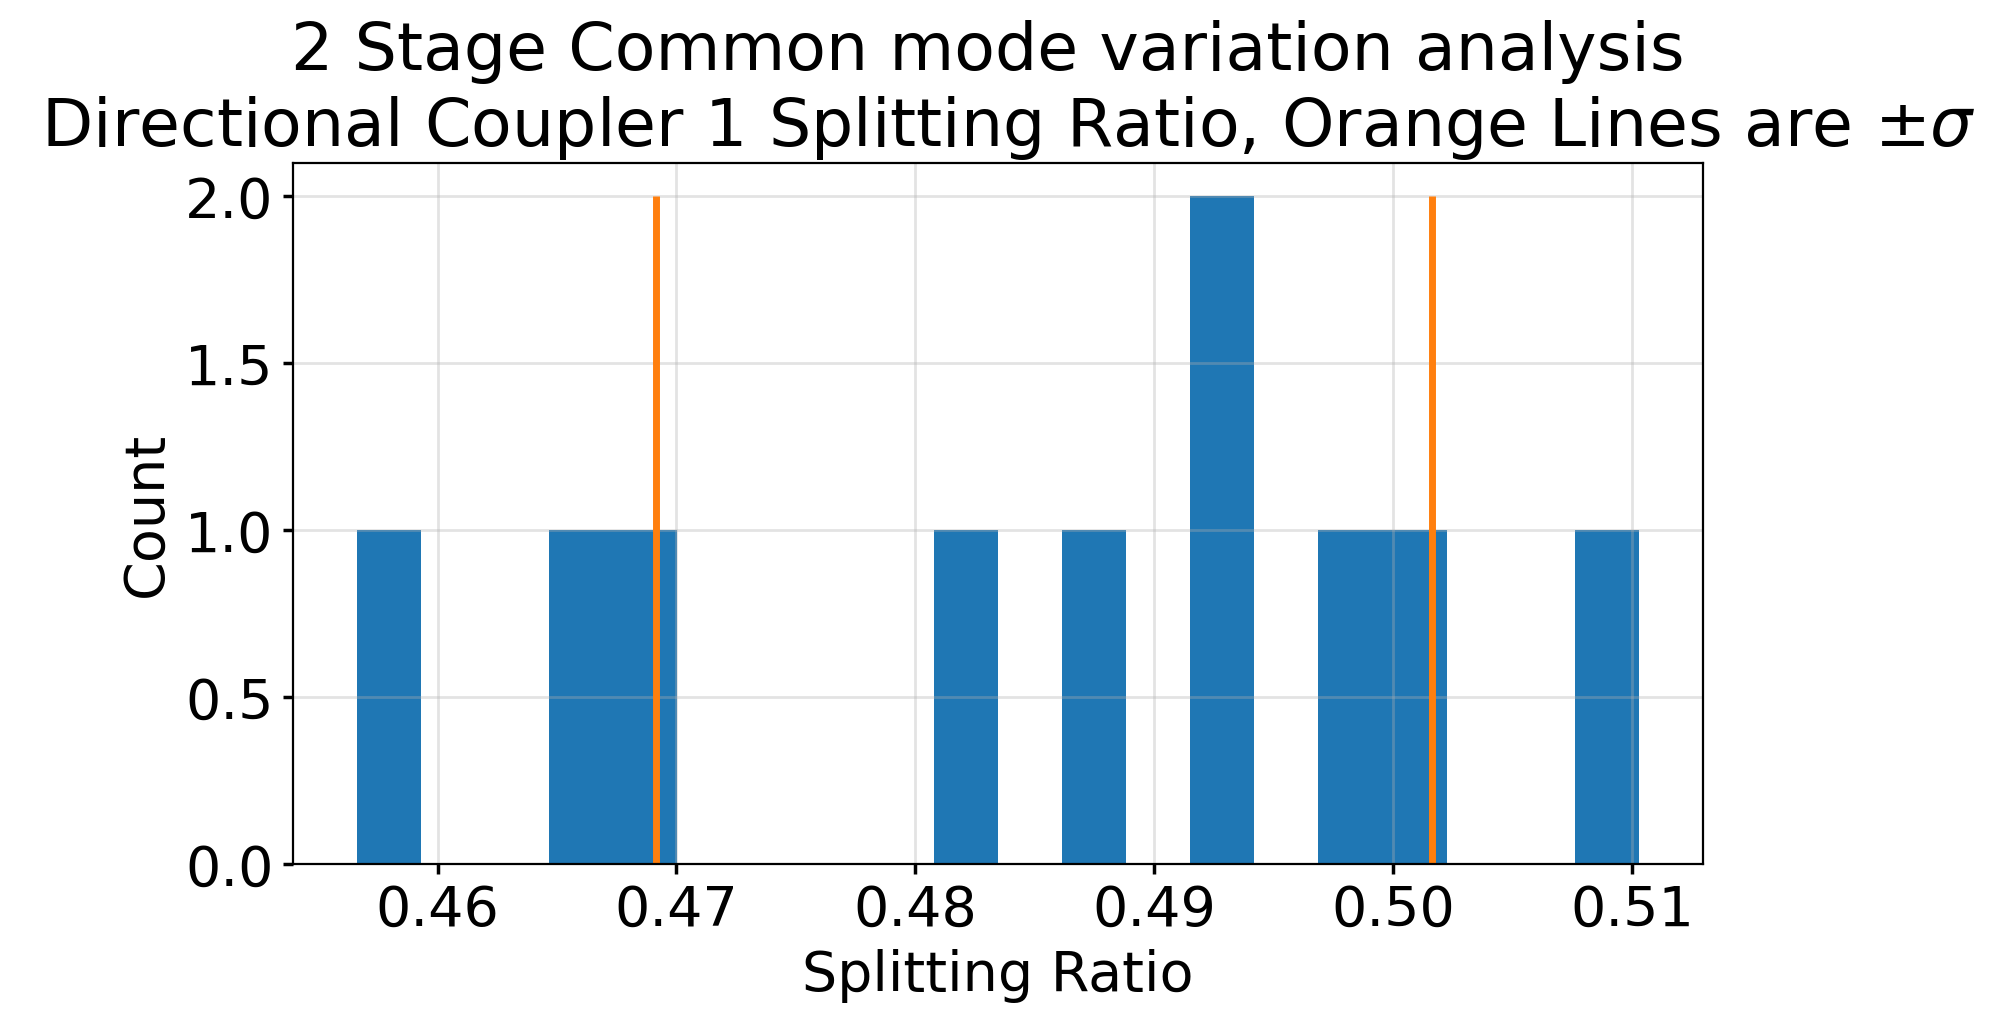

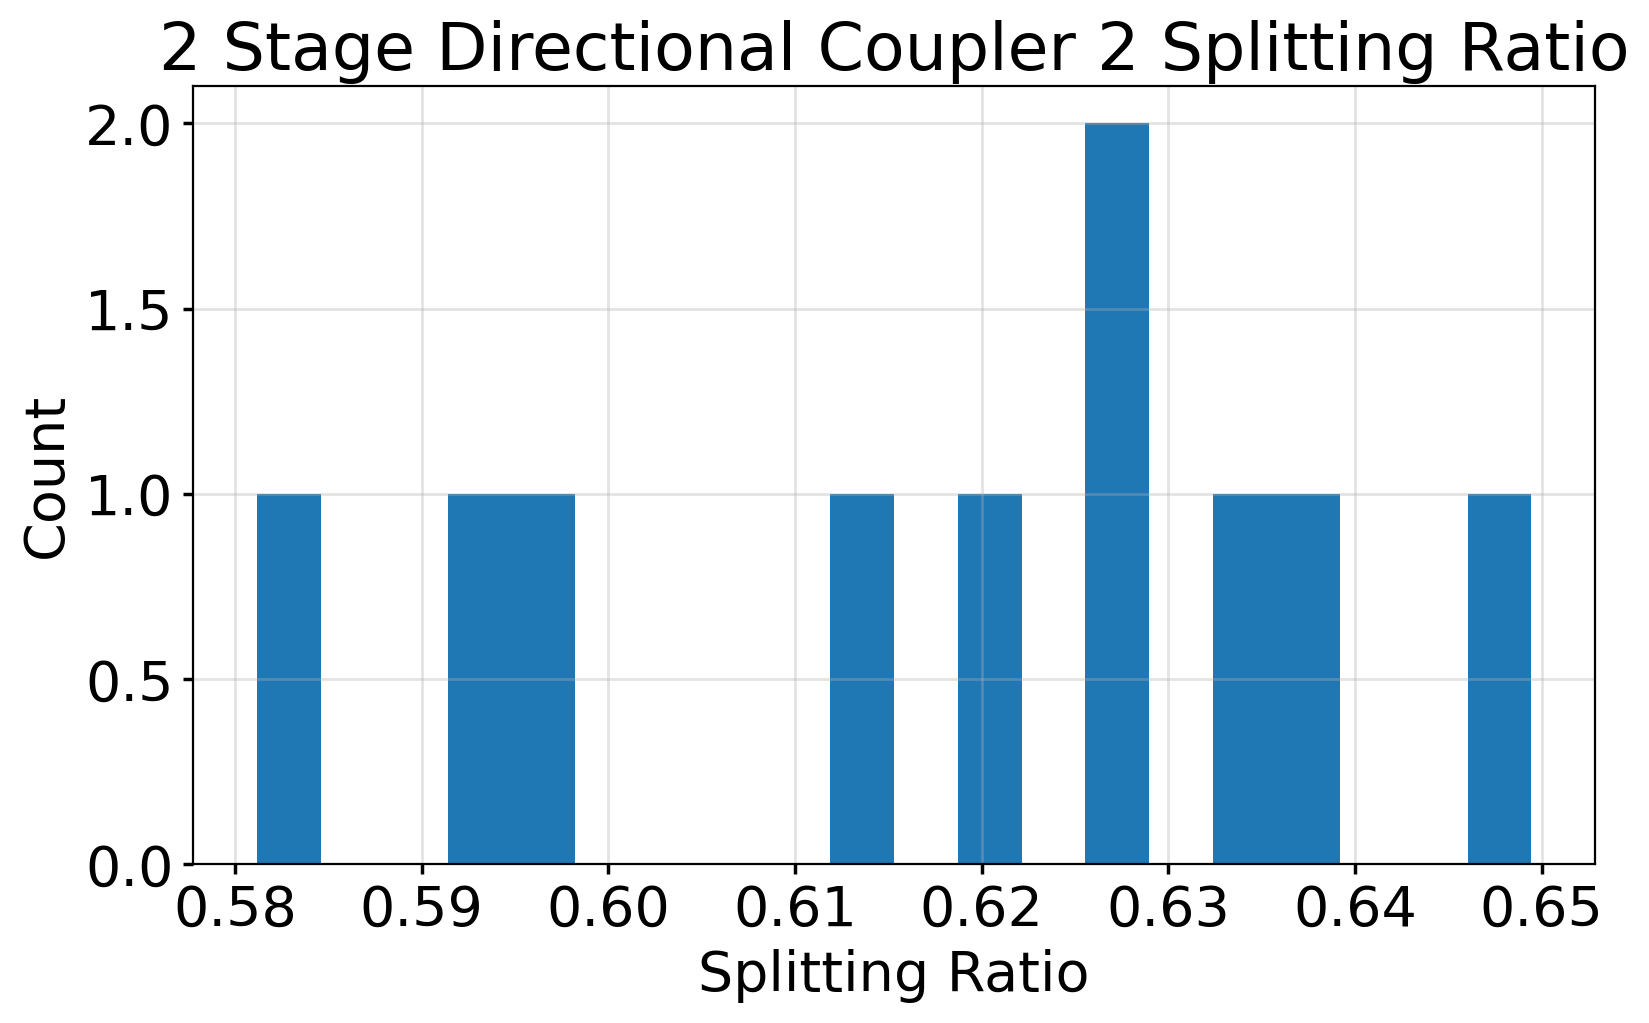

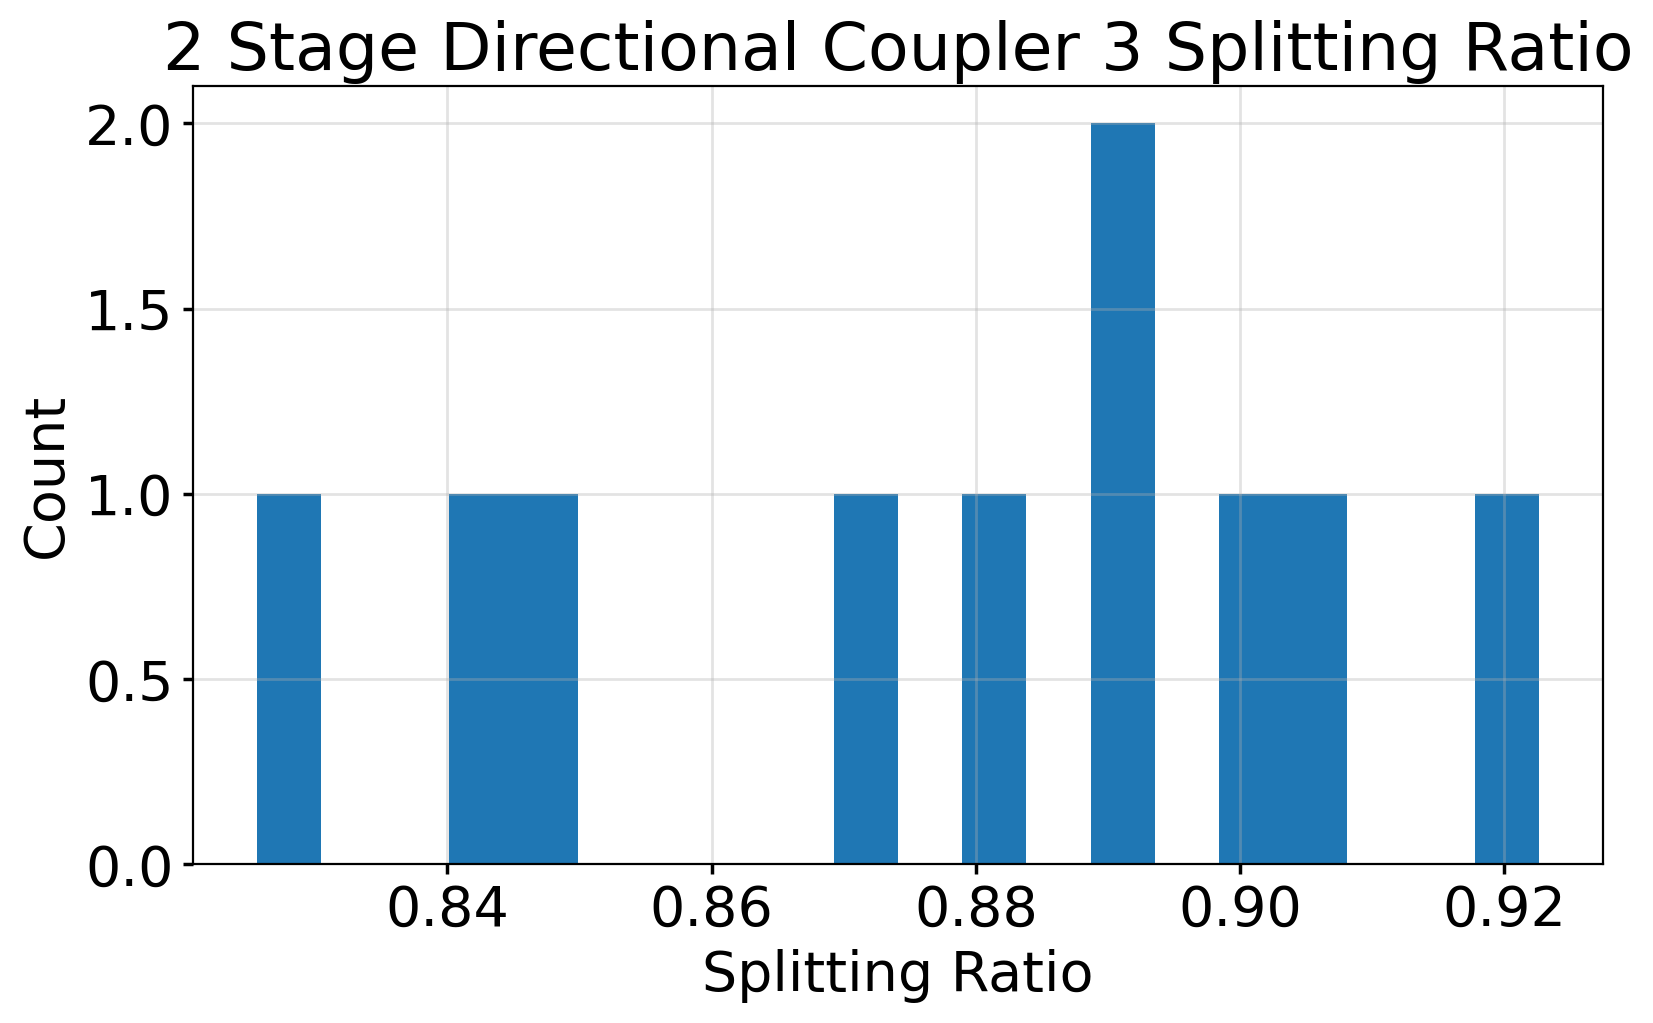

In [7]:
plt.figure()
plt.plot(wav*1e9,10*np.log10(total_bar_port_storage.T),alpha=0.002, c='C0')
plt.ylim(-5,1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bar Port Transmission (dB)")
plt.title("2 Stage Common mode variation analysis")
plt.xlim(1305,1315)
plt.show()

plt.figure()
plt.plot(wav*1e9,10*np.log10(total_cross_port_storage.T),alpha=0.002, c='C0')
plt.ylim(-5,1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross Port Transmission (dB)")
plt.title("2 Stage Common mode variation analysis")
plt.xlim(1305,1315)
plt.show()

plt.figure()
dc_hist_bins = plt.hist(dc1_storage,bins=20)
# print(dc_hist_bins)
dc_stddev = np.std(dc1_storage)
dc_mean   = np.mean(dc1_storage)
print("plus sigma is : ", dc_mean + dc_stddev)
print("minus sigma is : ", dc_mean - dc_stddev)
plt.vlines(dc_mean - dc_stddev,ymin=0,ymax=np.max(dc_hist_bins[0]),color='C1')
plt.vlines(dc_mean + dc_stddev,ymin=0,ymax=np.max(dc_hist_bins[0]),color='C1')
plt.title("2 Stage Common mode variation analysis \n Directional Coupler 1 Splitting Ratio, Orange Lines are " + r"$\pm \sigma$")
plt.xlabel("Splitting Ratio")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(dc2_storage,bins=20)
plt.title("2 Stage Directional Coupler 2 Splitting Ratio")
plt.xlabel("Splitting Ratio")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(dc3_storage,bins=20)
plt.title("2 Stage Directional Coupler 3 Splitting Ratio")
plt.xlabel("Splitting Ratio")
plt.ylabel("Count")
plt.show()

In [8]:
plt.figure()
for i in range (8):
    plt.hist(bar_port_bandwidth[:,i]/1e9, label="channel#{}".format(i+1), alpha=0.7)
plt.xlim([100,250])
plt.legend()
plt.xlabel('Bar Port Channel bandwidth (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range (7):
    plt.hist(bar_port_ch_fsr[:,i]/1e9, label="channel#{} to {}".format(i,i+1), alpha=0.7)
plt.legend()
plt.xlabel('Bar Port Channel FSR (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range (8):
    plt.hist((bar_port_ch_wavelength_storage[:,i]-c/center_wavelength)/1e9, label="channel#{}".format(i), alpha=0.7)
plt.legend()
plt.xlabel('Bar Port Channel Center Frequency (Ghz)')
plt.ylabel('Count')

plt.figure()
plt.hist((bar_port_ch_wavelength_storage[:,0]-bar_port_ch_wavelength_storage[:,7])/1e9, alpha=0.7)
plt.xlabel('Bar Port Corner Channel Offset (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range(len(Channel_offset_list)):
    plt.hist(bar_port_insertion_loss_ch_offset_storage[:,i], label="Ch offset#{} Ghz".format(Channel_offset_list[i]/1e9), alpha=0.7)
plt.legend()
plt.xlabel('Bar Port Channel Insertion Loss (dB)')
plt.ylabel('Count')

NameError: name 'bar_port_bandwidth' is not defined

<Figure size 1600x1000 with 0 Axes>

In [ ]:
plt.figure()
for i in range (8):
    plt.hist(cross_port_bandwidth[:,i]/1e9, label="channel#{}".format(i+1), alpha=0.7)
plt.xlim([100,250])
plt.legend()
plt.xlabel('Cross Port Channel bandwidth (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range (7):
    plt.hist(cross_port_ch_fsr[:,i]/1e9, label="channel#{} to {}".format(i,i+1), alpha=0.7)
plt.legend()
plt.xlabel('Cross Port Channel FSR (Ghz)')
plt.ylabel('Count')

plt.figure()
plt.hist((cross_port_ch_wavelength_storage[:,0]-cross_port_ch_wavelength_storage[:,7])/1e9, alpha=0.7)
plt.xlabel('Cross Port Corner Channel Offset (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range(len(Channel_offset_list)):
    plt.hist(cross_port_insertion_loss_ch_offset_storage[:,i], label="Ch offset#{} Ghz".format(Channel_offset_list[i]/1e9), alpha=0.7)
plt.legend()
plt.xlabel('Cross Port Channel Insertion Loss (dB)')
plt.ylabel('Count')

## Process variations in directional couplers and the waveguide

In [ ]:
# Create compound effect of the three filter stages on top of each other
um = 1e-6
dc1_storage = []
dc2_storage = []
dc3_storage = []

# DC values = [0.495132    0.630014    0.896570]
total_bar_port_storage = []
total_cross_port_storage = []
bar_port_bandwidth = []
bar_port_ch_fsr = []
cross_port_bandwidth = []
cross_port_ch_fsr = []
bar_port_ch_wavelength = []
cross_port_ch_wavelength = []
bar_port_insertion_loss_ch_offset = []
cross_port_insertion_loss_ch_offset = []

for i in tqdm(range(process_variation_num_samples),desc='All process variation sweep'):
    rand_variable_dc1 = np.random.normal(0,random_variable_sigma) 
    # rand_variable_dc2 = np.random.normal(0,random_variable_sigma) 
    # rand_variable_dc3 = np.random.normal(0,random_variable_sigma) 

    rand_dc1 = (1+rand_variable_dc1)*0.495
    rand_dc2 = (1+rand_variable_dc1)*0.630
    rand_dc3 = (1+rand_variable_dc1)*0.895

    #Clamp values between 0 and 1
    rand_dc1 = np.clip(rand_dc1,a_min=0,a_max=1)
    rand_dc2 = np.clip(rand_dc2,a_min=0,a_max=1)
    rand_dc3 = np.clip(rand_dc3,a_min=0,a_max=1)

    dc1_storage.append(rand_dc1)
    dc2_storage.append(rand_dc2)
    dc3_storage.append(rand_dc3)
    
    variation_interleaver = interleaver_2_stage_calc(
        L = 350*um,
        dL1 = dL_400Ghz_FSR,
        dL2 = 2*dL_400Ghz_FSR,
        dc1 = rand_dc1,
        dc2 = rand_dc2,
        dc3 = rand_dc3,
        effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[i],
        group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[i]
    )
    variation_interleaver.channel_spacing = FSR_wavelength/8

    variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]

    new_dev_params = [
        rand_dc1,
        rand_dc2,
        rand_dc3,
        interleaver_400Ghz_result.x[3],
        interleaver_400Ghz_result.x[4],
    ]

    wav,bar_port_first_amp,cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)
    
    total_bar_port_storage.append(bar_port_first_amp)
    total_cross_port_storage.append(cross_port_amp)
    bar_port_bw, bar_port_fsr, bar_port_center_wavelength, bar_IL_dB = calculate_spectrum_bandwidth(wav, bar_port_first_amp, IL_channel_offset = Channel_offset_list)
    cross_port_bw, cross_port_fsr, cross_port_center_wavelength, cross_IL_dB = calculate_spectrum_bandwidth(wav, cross_port_amp, IL_channel_offset = Channel_offset_list)
    bar_port_bandwidth.append(bar_port_bw)
    bar_port_ch_fsr.append(bar_port_fsr)
    cross_port_bandwidth.append(cross_port_bw)
    cross_port_ch_fsr.append(cross_port_fsr)
    bar_port_ch_wavelength.append(bar_port_center_wavelength)
    cross_port_ch_wavelength.append(cross_port_center_wavelength)
    bar_port_insertion_loss_ch_offset.append(bar_IL_dB)
    cross_port_insertion_loss_ch_offset.append(cross_IL_dB)

total_bar_port_storage = np.array(total_bar_port_storage)
total_cross_port_storage = np.array(total_cross_port_storage)
bar_port_bandwidth = np.array(bar_port_bandwidth)
cross_port_bandwidth = np.array(cross_port_bandwidth)
bar_port_ch_fsr = np.array(bar_port_ch_fsr)
cross_port_ch_fsr = np.array(cross_port_ch_fsr)
inseriton_loss_dB_storage = 10*np.log10(insertion_loss_storage)
bar_port_ch_wavelength_storage = np.array(bar_port_ch_wavelength)
cross_port_ch_wavelength_storage = np.array(cross_port_ch_wavelength)
bar_port_insertion_loss_ch_offset_storage = np.array(bar_port_insertion_loss_ch_offset)
cross_port_insertion_loss_ch_offset_storage = np.array(cross_port_insertion_loss_ch_offset)

In [ ]:
plt.figure()
plt.plot(wav*1e9,10*np.log10(total_bar_port_storage.T),alpha=0.002, c='C0')
plt.ylim(-5,1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bar Port Transmission (dB)")
plt.title("2 Stage Common mode variation analysis")
plt.xlim(1305,1315)
plt.show()

plt.figure()
plt.plot(wav*1e9,10*np.log10(total_cross_port_storage.T),alpha=0.002, c='C0')
plt.ylim(-5,1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross Port Transmission (dB)")
plt.title("2 Stage Common mode variation analysis")
plt.xlim(1305,1315)
plt.show()

plt.figure()
dc_hist_bins = plt.hist(dc1_storage,bins=20)
# print(dc_hist_bins)
dc_stddev = np.std(dc1_storage)
dc_mean   = np.mean(dc1_storage)
print("plus sigma is : ", dc_mean + dc_stddev)
print("minus sigma is : ", dc_mean - dc_stddev)
plt.vlines(dc_mean - dc_stddev,ymin=0,ymax=np.max(dc_hist_bins[0]),color='C1')
plt.vlines(dc_mean + dc_stddev,ymin=0,ymax=np.max(dc_hist_bins[0]),color='C1')
plt.title("2 Stage Common mode variation analysis \n Directional Coupler 1 Splitting Ratio, Orange Lines are " + r"$\pm \sigma$")
plt.xlabel("Splitting Ratio")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(dc2_storage,bins=20)
plt.title("2 Stage Directional Coupler 2 Splitting Ratio")
plt.xlabel("Splitting Ratio")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(dc3_storage,bins=20)
plt.title("2 Stage Directional Coupler 3 Splitting Ratio")
plt.xlabel("Splitting Ratio")
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure()
for i in range (8):
    plt.hist(bar_port_bandwidth[:,i]/1e9, label="channel#{}".format(i+1), alpha=0.7)
plt.xlim([100,250])
plt.legend()
plt.xlabel('Bar Port Channel bandwidth (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range (7):
    plt.hist(bar_port_ch_fsr[:,i]/1e9, label="channel#{} to {}".format(i,i+1), alpha=0.7)
plt.legend()
plt.xlabel('Bar Port Channel FSR (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range (8):
    plt.hist((bar_port_ch_wavelength_storage[:,i]-c/center_wavelength)/1e9, label="channel#{}".format(i), alpha=0.7)
plt.legend()
plt.xlabel('Bar Port Channel Center Frequency (Ghz)')
plt.ylabel('Count')

plt.figure()
plt.hist((bar_port_ch_wavelength_storage[:,0]-bar_port_ch_wavelength_storage[:,7])/1e9, alpha=0.7)
plt.xlabel('Bar Port Corner Channel Offset (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range(len(Channel_offset_list)):
    plt.hist(bar_port_insertion_loss_ch_offset_storage[:,i], label="Ch offset#{} Ghz".format(Channel_offset_list[i]/1e9), alpha=0.7)
plt.legend()
plt.xlabel('Bar Port Channel Insertion Loss (dB)')
plt.ylabel('Count')

In [ ]:
plt.figure()
for i in range (8):
    plt.hist(cross_port_bandwidth[:,i]/1e9, label="channel#{}".format(i+1), alpha=0.7)
plt.xlim([100,250])
plt.legend()
plt.xlabel('Cross Port Channel bandwidth (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range (7):
    plt.hist(cross_port_ch_fsr[:,i]/1e9, label="channel#{} to {}".format(i,i+1), alpha=0.7)
plt.legend()
plt.xlabel('Cross Port Channel FSR (Ghz)')
plt.ylabel('Count')

plt.figure()
plt.hist((cross_port_ch_wavelength_storage[:,0]-cross_port_ch_wavelength_storage[:,7])/1e9, alpha=0.7)
plt.xlabel('Cross Port Corner Channel Offset (Ghz)')
plt.ylabel('Count')

plt.figure()
for i in range(len(Channel_offset_list)):
    plt.hist(cross_port_insertion_loss_ch_offset_storage[:,i], label="Ch offset#{} Ghz".format(Channel_offset_list[i]/1e9), alpha=0.7)
plt.legend()
plt.xlabel('Cross Port Channel Insertion Loss (dB)')
plt.ylabel('Count')

In [ ]:
dc1_storage = np.array(dc1_storage)
dc2_storage = np.array(dc2_storage)
dc3_storage = np.array(dc3_storage)

In [ ]:
interleaver_2_stages = gf45clo_sin_neff_ng_variability.copy(deep=True)

interleaver_2_stages['dc1'] = dc1_storage
interleaver_2_stages['dc2'] = dc2_storage
interleaver_2_stages['dc3'] = dc3_storage

for ch in range(8):
    interleaver_2_stages['bar_port_bw_ch{}_Ghz'.format(ch+1)] = bar_port_bandwidth[:,ch]/1e9
for ch in range(7):
    interleaver_2_stages['bar_port_fsr_ch{}_to_ch{}_Ghz'.format(ch+1,ch+2)]=bar_port_ch_fsr[:,ch]/1e9
for ch in range(8):
    interleaver_2_stages['bar_port_center_wavelength_offset_ch{}_Ghz'.format(ch+1)]=(bar_port_ch_wavelength_storage[:,ch]-c/center_wavelength)/1e9
for ch in range(len(Channel_offset_list)):
    interleaver_2_stages['insertion_loss_ch_offset_{}_Ghz'.format(int(Channel_offset_list[ch]/1e9))] = bar_port_insertion_loss_ch_offset_storage[:,ch]

In [ ]:
interleaver_2_stages.to_csv('interleaver_2_stages_common_mode_variability.csv')